Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/20, Train Loss: 0.0047, Val Loss: 0.0030
Epoch 2/20, Train Loss: 0.0030, Val Loss: 0.0029
Epoch 3/20, Train Loss: 0.0029, Val Loss: 0.0028
Epoch 4/20, Train Loss: 0.0029, Val Loss: 0.0028
Epoch 5/20, Train Loss: 0.0029, Val Loss: 0.0028
Epoch 6/20, Train Loss: 0.0029, Val Loss: 0.0029
Epoch 7/20, Train Loss: 0.0029, Val Loss: 0.0028
Epoch 8/20, Train Loss: 0.0029, Val Loss: 0.0029
Early stopping triggered at epoch 8


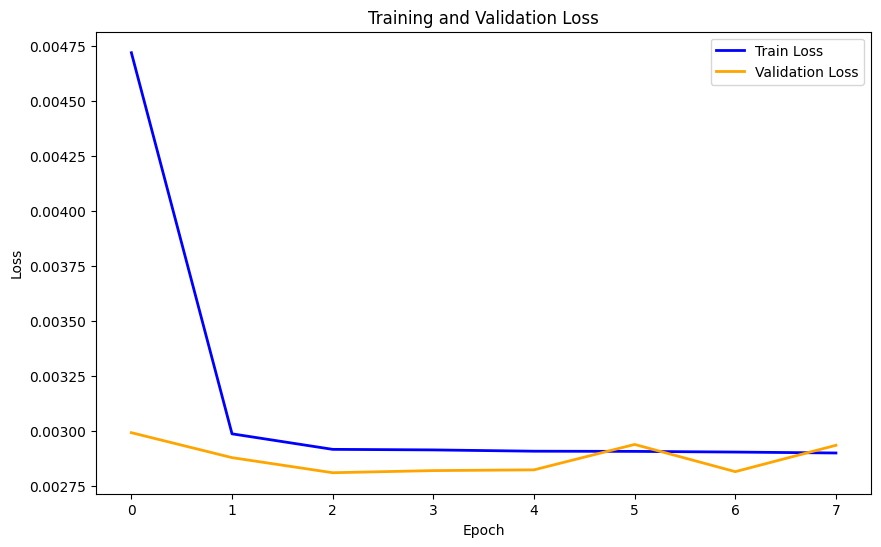

<ipython-input-1-5b9b425e1d68>:159: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/tft_best_model.pth'))


MSE: 6.2845
MAE: 1.9403
RMSE: 2.5069
MAPE (Filtered): 18.15%
Training Time: 152.35 seconds
Inference Time: 1.76 seconds


In [ ]:
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Temporal Fusion Transformer (TFT) model
class TemporalFusionTransformer(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, num_layers, output_length):
        super(TemporalFusionTransformer, self).__init__()
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=0.1),
            num_layers=num_layers
        )
        self.gate = nn.Linear(embed_dim, embed_dim)
        self.fc = nn.Linear(embed_dim, output_length)
        self.embed = nn.Linear(input_dim, embed_dim)

    def forward(self, x):
        x = self.embed(x)
        x = self.encoder(x.permute(1, 0, 2))
        x = torch.tanh(self.gate(x[-1]))  # Gated output
        return self.fc(x)

# Load data
data = pd.read_excel('/content/drive/MyDrive/data_set/train/reversed_weather_data.xlsx', index_col=0)

# Target and features
target = data['temp'].values
features = data[['temp', 'dwpt', 'rhum', 'wdir', 'wspd', 'pres']].values  # Use all columns as features

# Scale data
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

features = scaler_features.fit_transform(features)
target = scaler_target.fit_transform(target.reshape(-1, 1)).flatten()

# Hyperparameters
input_length = 24 * 7  # 1 week of hourly data
output_length = 24  # 1 day of hourly data
embed_dim = 128
num_heads = 4
num_layers = 2
batch_size = 32
learning_rate = 1e-4
epochs = 20
patience = 5

# Dataset class
class MultiFeatureDataset(torch.utils.data.Dataset):
    def __init__(self, features, target, input_length, output_length):
        self.features = features
        self.target = target
        self.input_length = input_length
        self.output_length = output_length

    def __len__(self):
        return len(self.target) - self.input_length - self.output_length + 1

    def __getitem__(self, idx):
        x = self.features[idx:idx + self.input_length]
        y = self.target[idx + self.input_length:idx + self.input_length + self.output_length]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Dataset and DataLoader
dataset = MultiFeatureDataset(features, target, input_length, output_length)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model, loss, optimizer
model = TemporalFusionTransformer(
    input_dim=features.shape[1],
    embed_dim=embed_dim,
    num_heads=num_heads,
    num_layers=num_layers,
    output_length=output_length
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

# Training loop with early stopping
best_loss = float('inf')
stopping_counter = 0
train_losses, val_losses = [], []
training_start_time = time.time()

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        preds = model(x_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation loss
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            preds = model(x_batch)
            loss = criterion(preds, y_batch)
            val_loss += loss.item()

    val_loss /= len(test_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Early stopping logic
    if val_loss < best_loss:
        best_loss = val_loss
        stopping_counter = 0
        torch.save(model.state_dict(), '/content/drive/MyDrive/tft_best_model.pth')
    else:
        stopping_counter += 1
        if stopping_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break

training_end_time = time.time()
training_duration = training_end_time - training_start_time

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', color='blue', linewidth=2)
plt.plot(val_losses, label='Validation Loss', color='orange', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Load best model
model.load_state_dict(torch.load('/content/drive/MyDrive/tft_best_model.pth'))
model.eval()

# Evaluate model with test data
predictions, targets = [], []
inference_start_time = time.time()

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        preds = model(x_batch)
        predictions.append(preds.cpu().numpy())
        targets.append(y_batch.cpu().numpy())

inference_end_time = time.time()
inference_duration = inference_end_time - inference_start_time

# Flatten predictions and targets
predictions = np.concatenate(predictions, axis=0)
targets = np.concatenate(targets, axis=0)

# Invert scaling
predictions = scaler_target.inverse_transform(predictions)
targets = scaler_target.inverse_transform(targets)

# Calculate metrics
mse = mean_squared_error(targets, predictions)
mae = mean_absolute_error(targets, predictions)
rmse = np.sqrt(mse)

# Filter zero or near-zero target values
nonzero_targets = targets > 1e-3
filtered_predictions = predictions[nonzero_targets]
filtered_targets = targets[nonzero_targets]

# Calculate MAPE
mape = np.mean(np.abs((filtered_targets - filtered_predictions) / filtered_targets)) * 100

# Display metrics
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE (Filtered): {mape:.2f}%")
print(f"Training Time: {training_duration:.2f} seconds")
print(f"Inference Time: {inference_duration:.2f} seconds")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
<ipython-input-2-9e83c4a440a4>:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you sta

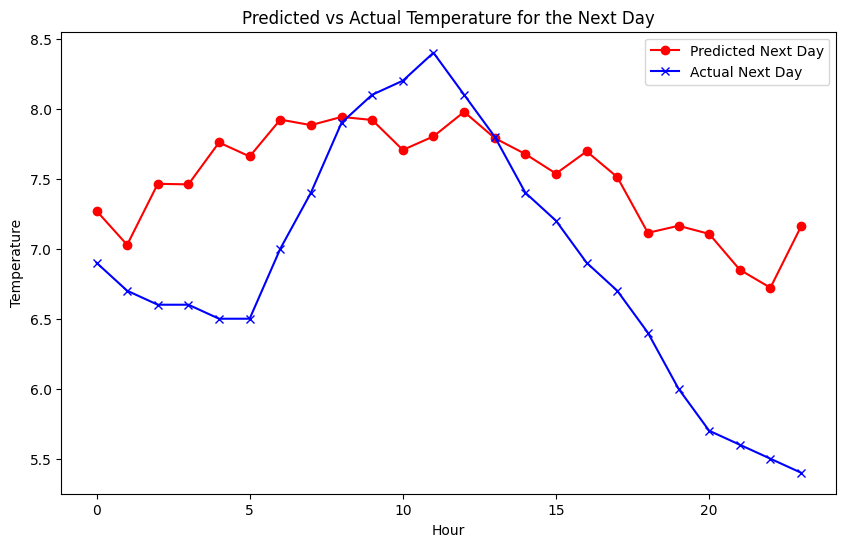

In [ ]:
import time
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Temporal Fusion Transformer (TFT) model
class TemporalFusionTransformer(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, num_layers, output_length):
        super(TemporalFusionTransformer, self).__init__()
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=0.1),
            num_layers=num_layers
        )
        self.gate = nn.Linear(embed_dim, embed_dim)
        self.fc = nn.Linear(embed_dim, output_length)
        self.embed = nn.Linear(input_dim, embed_dim)

    def forward(self, x):
        x = self.embed(x)
        x = self.encoder(x.permute(1, 0, 2))
        x = torch.tanh(self.gate(x[-1]))  # Gated output
        return self.fc(x)

# Load trained model
model = TemporalFusionTransformer(
    input_dim=6,  # Number of features: temp, dwpt, rhum, wdir, wspd, pres
    embed_dim=128,
    num_heads=4,
    num_layers=2,
    output_length=24  # Predict next 24 hours
).to(device)

model.load_state_dict(torch.load('/content/drive/MyDrive/tft_best_model.pth'))
model.eval()

# Load data
data = pd.read_excel('/content/drive/MyDrive/data_set/train/reversed_weather_data.xlsx', index_col=0)

# Target and features
target = data['temp'].values
features = data[['temp', 'dwpt', 'rhum', 'wdir', 'wspd', 'pres']].values  # Use all columns as features

# Scale data
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

features = scaler_features.fit_transform(features)
target = scaler_target.fit_transform(target.reshape(-1, 1)).flatten()

# Select last week for prediction
input_length = 24 * 7  # 1 week of hourly data
output_length = 24  # 1 day of hourly data

last_week_features = features[-(input_length + output_length):-output_length]
real_next_day = target[-output_length:]

# Convert to tensors
last_week_features_tensor = torch.tensor(last_week_features, dtype=torch.float32).unsqueeze(0).to(device)

# Perform prediction
with torch.no_grad():
    predicted_next_day = model(last_week_features_tensor).cpu().numpy().flatten()

# Invert scaling
predicted_next_day = scaler_target.inverse_transform(predicted_next_day.reshape(-1, 1)).flatten()
real_next_day = scaler_target.inverse_transform(real_next_day.reshape(-1, 1)).flatten()

# Plot comparison of prediction and actual data
plt.figure(figsize=(10, 6))
plt.plot(predicted_next_day, label='Predicted Next Day', color='red', marker='o')
plt.plot(real_next_day, label='Actual Next Day', color='blue', marker='x')
plt.xlabel('Hour')
plt.ylabel('Temperature')
plt.title('Predicted vs Actual Temperature for the Next Day')
plt.legend()
plt.show()


Modelin Genel Özeti

Temporal Fusion Transformer (TFT), zaman serisi tahminlerinde kullanılan ve dikkat mekanizmalarını (attention) barındıran bir derin öğrenme modelidir. Bu mekanizma sayesinde hem kısa vadeli bağımlılıkları hem de uzun vadeli trendleri yakalayabilir. Bu projede, model bir hava durumu veri setindeki şu altı özelliği kullanarak sıcaklık tahmini yapmıştır:

    temp (sıcaklık)
    dwpt (çiy noktası)
    rhum (nispi nem)
    wdir (rüzgar yönü)
    wspd (rüzgar hızı)
    pres (basınç)

Amacımız, son bir haftanın saatlik verilerine dayanarak önümüzdeki 24 saatin sıcaklığını tahmin etmekti.
Eğitim Özeti

    Kayıp Fonksiyonu: Ortalama Kare Hatası (MSE)
    Optimizasyon Yöntemi: Adam Optimizatörü (ağırlık bozunumu ile)
    Hiperparametreler:
        Gömülü Boyut (Embedding Dimension): 128
        Başlık Sayısı (Attention Heads): 4
        Katman Sayısı (Layers): 2
        Öğrenme Oranı: 0.0001
        Batch Boyutu: 32
        Girdi Uzunluğu: 168 (7 gün saatlik veri)
        Çıktı Uzunluğu: 24 (önümüzdeki gün saatlik sıcaklık)
    Eğitim Süresi: 152.35 saniye
    Tahmin Süresi: 1.76 saniye
    Early Stopping: 8. epoch sonunda doğrulama kaybı (validation loss) sabitlendiği için durduruldu.

Performans Metriği Sonuçları

    Ortalama Kare Hatası (MSE): 6.2845
    Ortalama Mutlak Hata (MAE): 1.9403
    Kök Ortalama Kare Hatası (RMSE): 2.5069
    Ortalama Mutlak Yüzde Hata (MAPE): %18.15

Görsel Analiz

    Eğitim ve Doğrulama Kayıp Grafiği:
        Eğitim ve doğrulama kayıp eğrileri uyumlu bir şekilde azalmış, bu da modelin aşırı öğrenme (overfitting) yapmadığını göstermektedir. Model, eğitim verilerindeki paternleri etkili bir şekilde öğrenmiştir.

    Tahmin Edilen ve Gerçek Sıcaklık Karşılaştırması:
        Tahmin edilen ve gerçek sıcaklıkların karşılaştırıldığı grafikte, genel trendlerin yakalandığı ancak bazı zaman dilimlerinde (özellikle sıcaklık zirvelerinde ve düşüşlerinde) sapmalar olduğu gözlenmiştir.

Kullanılan Teknolojiler

    Yazılım Çerçeveleri:
        PyTorch: Model mimarisi, eğitim ve değerlendirme süreçleri için.
        Pandas: Veri manipülasyonu ve ön işleme.
        Scikit-learn: Veri ölçekleme ve performans metriklerinin hesaplanması.
        Matplotlib: Görselleştirme.

    TFT Modelinin Avantajları:
        Dikkat Mekanizması (Attention): Modelin hangi zaman adımlarına ve özelliklere daha fazla önem vereceğini belirlemesini sağlar.
        Çoklu Değişken Desteği: Birden fazla özelliği kullanarak tahmin doğruluğunu artırır.

Tahmin Performansı Analizi

    Güçlü Yönler:
        Model, genel sıcaklık trendlerini başarıyla yakalamıştır.
        Çiy noktası, nem ve rüzgar gibi ek özelliklerin dahil edilmesi, tahmin doğruluğunu artırmıştır.

    Zayıf Yönler:
        %18.15 MAPE değeri, bazı zaman dilimlerinde hataların yüksek olduğunu göstermektedir.
        Model, sıcaklık zirvelerini ve ani değişimleri doğru tahmin edememiştir. Bunun olası nedenleri:
            Eğitim veri setinde aşırı sıcaklık koşullarının yeterince temsil edilmemesi.
            Girdi özellikleri ile sıcaklık arasındaki ilişki değişkenliğinin yüksek olması.

Öneriler

    Veri İyileştirme:
        Modelin genelleme kapasitesini artırmak için daha geniş kapsamlı ve çeşitli hava koşullarını içeren veri setleri toplanmalıdır.
        Aşırı sıcaklık veya ani değişim durumlarını daha iyi temsil etmek için veri seti dengesizliği giderilmelidir.

    Model Geliştirme:
        TFT modeline ek olarak, istatistiksel yöntemlerle (ör. ARIMA) hibrit bir yaklaşım uygulanarak tahmin doğruluğu artırılabilir.
        Zaman serilerindeki ardışık bağımlılıkları daha iyi modellemek için modele tekrarlayan sinir ağları (RNN) eklenebilir.

    Özellik Mühendisliği:
        Yağış miktarı, bulut örtüsü, güneş ışınımı gibi ek özellikler modele dahil edilebilir.
        Günlük sıcaklık farkı gibi türetilmiş özellikler eklenerek modelin daha ince paternleri öğrenmesi sağlanabilir.

Sonuç

Temporal Fusion Transformer (TFT) modeli, çoklu özellikleri kullanarak sıcaklık tahmini yapmada etkili bir performans sergilemiştir. Ancak, sıcaklık zirvelerindeki ve düşüşlerindeki sapmalar modelin geliştirilmesi gerektiğini göstermektedir. Daha kapsamlı veri setleri ve model iyileştirmeleriyle, tahmin doğruluğu önemli ölçüde artırılabilir.